In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

import tetrahedron

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [418]:
import sys

sys.path.append("../..")

from pivot import metric 

In [ ]:
assert False, "The projection is buggy! The lower bounds extracted from the projected space are somehow wrong!"

In [483]:
# simulate triangles
rng = np.random.default_rng()

dist_func = lambda x,y: spatial.minkowski_distance(x,y,2)# np.linalg.norm(x-y, axis=-1)
n_samples = 10000
dim = 3
points = rng.integers(-37,38, size=[n_samples, dim])
#p0,p1,q,o = 0,1,2,3

#p0, p1 = np.array([-30]*dim).T, np.array([30]*dim).T
p0, p1 = points[0], points[1]
points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1, dist_func)

<lambdifygenerated-372>:2: RuntimeWarning: invalid value encountered in sqrt
  return select([greater(o1**2, o0**2 + 390.0),True], [-sqrt(o0**2 + 0.000641025641025641*(-o0 - o1 + 19.7484176581315)*(-o0 + o1 + 19.7484176581315)*(o0 - o1 + 19.7484176581315)*(o0 + o1 + 19.7484176581315)),sqrt(o0**2 + 0.000641025641025641*(-o0 - o1 + 19.7484176581315)*(-o0 + o1 + 19.7484176581315)*(o0 - o1 + 19.7484176581315)*(o0 + o1 + 19.7484176581315))], default=nan)


In [484]:
def calc_scale(points, dist_func, knn=10):
    """Calculate the average knn distance"""
    SAMPLE_SIZE = 100
    queries = rng.choice(points, size=SAMPLE_SIZE)
    k_range = [np.sort(dist_func(q, points))[knn] for q in queries]
    return np.mean(k_range)

def range_query(points, query_center, radius, dist_func, return_indices=False):
    """Return all points within the radius of query_center"""
    dist = dist_func(query_center, points)
    if return_indices:
        return np.nonzero(dist <= radius)[0]
    else:
        return points[dist <= radius]

def set_of_points(points):
    return list(map(tuple, points))

In [485]:
from scipy import stats

def rate_pivot_overhead(points_orig, points_piv, dist_func_orig, dist_func_piv):
    assert len(points_orig) == len(points_piv)
    
    mean_query_range = calc_scale(points_orig, dist_func_orig)
    #kde = stats.gaussian_kde(points_piv)
    
    SAMPLE_SIZE = 100
    q_center_idx = rng.integers(0, len(points_orig), size=SAMPLE_SIZE)
    
    query_conf_piv = dict(
        points=points_piv, radius=mean_query_range,
        dist_func=dist_func_piv, return_indices=True
    )
    candidates = [range_query(query_center=points_piv[q], **query_conf_piv) for q in q_center_idx]

    query_conf_orig = dict(
        points=points_orig, radius=mean_query_range,
        dist_func=dist_func_orig,return_indices=True
    )
    controls = [range_query(query_center=points_orig[q], **query_conf_orig) for q in q_center_idx]

    #return candidates, controls
    assert all([
        set(actual_set).issubset(set(candidate_set))
        for candidate_set, actual_set
        in zip(candidates, controls)
    ]), "The actual query solution must be a subsets of the candidate set from the pivot space!"

    unnecessary_dist_evals = [
        len(candidate_set) - len(actual_set)
        for candidate_set, actual_set
        in zip(candidates, controls)
    ]
    return np.mean(unnecessary_dist_evals), np.std(unnecessary_dist_evals, ddof=1)

rate_pivot_efficency(points, points_p, dist_func, dist_func)

(9983.16, 3.47493187201584)

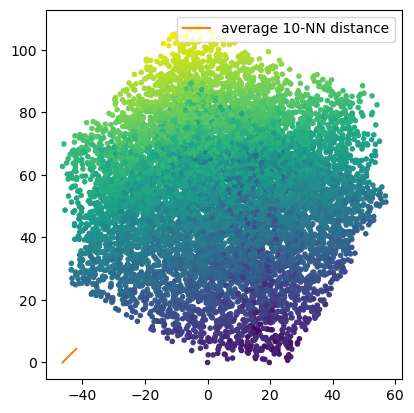

In [488]:


nans = np.isnan(points_p).sum(axis=1).astype("bool")
points_p = points_p[~nans,:]

c = points[~nans,:].sum(axis=1)

#closer_to_p0 = dist_func(points, p0) < dist_func(points, p1)
plt.scatter(*points_p.T,c=c, marker=".")


# plot distance gauge
ten_nn_dist = np.sort(dist_func([0]*dim, points))[9]
plt.plot(
    [points_p[:,0].min(),points_p[:,0].min()+ten_nn_dist],
    [points_p[:,1].min(),points_p[:,1].min()+ten_nn_dist],
    color="C1",
    label="average 10-NN distance"
)

plt.legend()
plt.gca().set_aspect('equal');

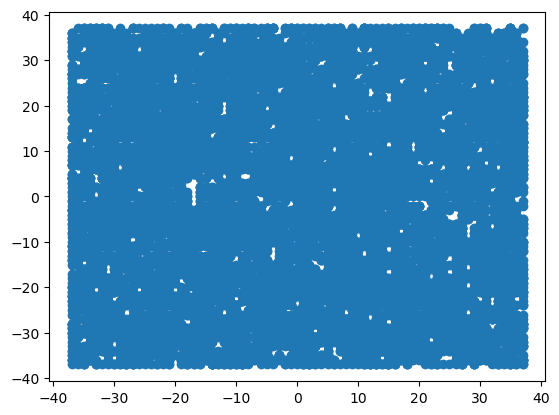

In [489]:
plt.scatter(*points.T[:2])

In [302]:
close_to_p1 = np.argsort(dist_func(p1, points))
next_pivs = points[close_to_p1]

<lambdifygenerated-323>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.0419830323293669*sqrt((-o0 + o1 + 141.837935687178)*(o0 - o1 + 141.837935687178)*(o0 + o1 - 141.837935687178))*sqrt(0.00705030001427467*o0 + 0.00705030001427467*o1 + 1)


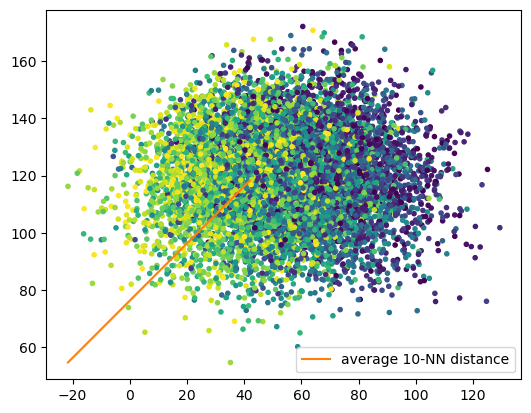

In [314]:
p1_new = next_pivs[-20]
points_p = tetrahedron.project_to_2d_euclidean(points, p0, p1_new, dist_func)

nans = np.isnan(points_p).sum(axis=1).astype("bool")
points_p = points_p[~nans,:]
c = points[~nans,0]

#closer_to_p0 = dist_func(points, p0) < dist_func(points, p1)
plt.scatter(*points_p.T,c=c, marker=".")


# plot distance gauge
ten_nn_dist = np.sort(dist_func([0]*dim, points))[9]
plt.plot(
    [points_p[:,0].min(),points_p[:,0].min()+ten_nn_dist],
    [points_p[:,1].min(),points_p[:,1].min()+ten_nn_dist],
    color="C1",
    label="average 10-NN distance"
)

plt.legend()
plt.gca().set_aspect('equal');